---
title: Neural Networks Foundation — From Theory to Practice
jupyter: python3
execute:
  freeze: true
  echo: true
toc: true
toc-depth: 4
number-sections: true
format:
  html:
    toc-expand: false
---

# Introduction

For any machine learning or deep learning model to improve, it must learn from its own performance—specifically, by iteratively adjusting its parameters (weights) until predictions align with reality.

Stochastic Gradient Descent (SGD) is the cornerstone of this optimization process and remains the  widely used optimization algorithm in modern AI.

In this article, I'll:
* Build an intuitive understanding of SGD.
* Walk through a simple example of gradient descent.
* Apply these concepts by creating a learner from scratch and training it on the MNIST dataset.

# The Intuition Behind Gradient Descent

Consider the case where we have a set of 2-D points $p(x, y)$ emulating a natural phenomenon, and we want to model their behavior using a quadratic equation:

$y = a.x^2 + b.x + c$

To find the best values for $a$, $b$, and $c$, we usually would:

* Choose initial (random) values for $a$, $b$, and $c$.

* Make predictions $\hat{y}$ for all $x$ using these weights.

* Compare predictions to the true $y$ values and compute the error.

* Figure out how to adjust $a$, $b$, and $c$ to reduce the error (increase or decrease).

* Repeat this process until the error is as small as possible.

However, how would we instill this intuition on how to correctly adjust the weights to our model?

The answer lies in gradient descent.

The idea behind gradient descent is to compute the derivative of a function ( in our case, the error function) at some point (the point being the weights chosen). This will tell us how steeply the error changes with respect to each parameter.

And since we are trying to minimize this error, take iterative steps in the opposite direction of the gradient because that's where the steepest descent is.

$ w=w - η⋅∇L $

Where:

  $\eta$ is the learning rate

  $\nabla{L}$ is the gradient of the loss function

## Example

Let's say our loss function is as follow:

 $f(w) = (w -5)^2 $

 At first glance, it is obvious that the value of $w$ that would minimize $f(w)$ is 5.

 But let's do that with SGD.
 * Start with $w_0 = 0$, and a learning rate $\eta = 0.1$.
 * Compute gradient $\nabla{f(w)} = 2 * (w -5)$
 * Iteration 1:
 $w_1 = w_0 - \eta⋅\nabla{f(w_0)} = 0 - 0.1 * 2(0 - 5) = 1  $

  * Iteration 2:
 $w_2 = w_1 - \eta⋅\nabla{f(w_1)} = 1 - 0.1 * 2(1 - 5) = 1.4  $

As we can see each step is moving us closer to the solution $w = 5$.
## Why "Stochastic"?

In Stochastic Gradient Descent (SGD), instead of computing the gradient using the entire dataset at once—which would be computationally heavy, we use just one data point or a small random batch.
This makes updates faster and helps the model escape local minima, as it adds a bit of randomness.


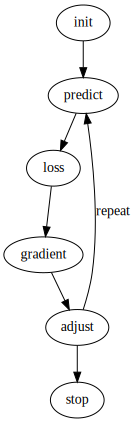

In [ ]:
!pip install graphviz
from graphviz import Digraph

dot = Digraph(comment='Gradient Descent Process')

dot.edge('init', 'predict')
dot.edge('predict', 'loss')
dot.edge('loss', 'gradient')
dot.edge('gradient', 'adjust')
dot.edge('adjust', 'stop')
dot.edge('adjust', 'predict', label='repeat')

# Render in notebook
dot.render('gradient_descent', format='png', view=True)  # saves and opens the file

# To just display in Jupyter notebook:
dot

#  From Theory to Practice: Creating a Learner from scratch on MNIST

Using the [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) which is a collection of handwritten digits, I'll apply SGD to train a neural network.

## Setup

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
! [ -e /content ] && pip install -Uqq fastbook
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 792.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
Mounted at /content/gdrive


## Dataset Preparation


In chapter <4>, only a sample of the mnist dataset was used, but in my case I need data for all digits.
To do that, I went onto fastai[ documentation page](https://docs.fast.ai/data.external.html) to check available URLs.

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = None) -> 'Path'
    Download `url` using `FastDownload.get`



In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
print(path.ls())
print((path/'train').ls().sorted())
path = untar_data(URLs.MNIST)
print(path.ls())
print((path/'training').ls().sorted())
print((path/'testing').ls().sorted())

[Path('/root/.fastai/data/mnist_sample/train'), Path('/root/.fastai/data/mnist_sample/labels.csv'), Path('/root/.fastai/data/mnist_sample/valid')]
[Path('/root/.fastai/data/mnist_sample/train/3'), Path('/root/.fastai/data/mnist_sample/train/7')]


[Path('/root/.fastai/data/mnist_png/testing'), Path('/root/.fastai/data/mnist_png/training')]
[Path('/root/.fastai/data/mnist_png/training/0'), Path('/root/.fastai/data/mnist_png/training/1'), Path('/root/.fastai/data/mnist_png/training/2'), Path('/root/.fastai/data/mnist_png/training/3'), Path('/root/.fastai/data/mnist_png/training/4'), Path('/root/.fastai/data/mnist_png/training/5'), Path('/root/.fastai/data/mnist_png/training/6'), Path('/root/.fastai/data/mnist_png/training/7'), Path('/root/.fastai/data/mnist_png/training/8'), Path('/root/.fastai/data/mnist_png/training/9')]
[Path('/root/.fastai/data/mnist_png/testing/0'), Path('/root/.fastai/data/mnist_png/testing/1'), Path('/root/.fastai/data/mnist_png/testing/2'), Path('/root/.fastai/data/mnist_png/testing/3'), Path('/root/.fastai/data/mnist_png/testing/4'), Path('/root/.fastai/data/mnist_png/testing/5'), Path('/root/.fastai/data/mnist_png/testing/6'), Path('/root/.fastai/data/mnist_png/testing/7'), Path('/root/.fastai/data/mnist

In [ ]:
train_0 = Path(os.path.join(path,'training','0')).ls().sorted()
print(len(train_0))

5923


I checked with the `sorted` that I do, in fact, have all the digits needed.
Now let's check the type and shape of images in the dataset.

In [ ]:
im0_path = train_0[0]
im0 = Image.open(im0_path)
print(im0.shape)
im0

(28, 28)


### Preprocessing

To prepare the training set, the following steps are necessary:

1. Collect all training images.
2. Normalize pixel values to the range [0, 1].
3. Reshape the images into a stack of flattened vectors with shape (num_images, 28 * 28) in float32 format.
4. Prepare the corresponding labels (y).

### Multi-Class Classification

Since there are multiple categories, this is no longer a binary classification problem. Two intuitive approaches arise:

* Binary Classifiers per Label
  * Train an independent binary classifier for each label.
  * **Issue**: Fails to account for mutual exclusivity (an image could erroneously receive multiple labels).

* One-Hot Encoding

  * Represent labels as sparse vectors (e.g., [0, 1, 0, ..., 0] for label 1).
  * **Drawback**: Memory-inefficient (stores n_classes values per sample) and less intuitive for direct indexing.

* Integer Labels
A simpler and more efficient approach is to use integer encoding (e.g., y = 2 for class 2). Advantages include:

  * Memory efficiency: Stores a single integer per sample instead of a full vector.
  * Debugging simplicity: Easier to interpret and index during model evaluation.

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

def get_set(path, set_type="training"):
  """Returns a set (x, y) of tensors.
  Where x is the dependent variable and y the independant variable.
  Args:
    path (str): full path to the root folder containing the images.
    set_type (str): Desired set. Values [training, test].
  Returns:
    x(n_images, 28 * 28), y(n_images).
  """
  imgs = []
  labels = []
  for idx, digit_path in enumerate((path/set_type).ls().sorted()):
      img_paths = digit_path.ls().sorted()
      # Convert each image to a tensor
      # And scale it accordingly into [0,1] range
      imgs += [transforms.ToTensor()(Image.open(im_path)) for im_path in img_paths]
      # Add one label per image
      labels += [idx for _ in range(len(img_paths))]

  # Stack into tensors
  return torch.stack(imgs).float().view(-1, 28*28), torch.tensor(labels, dtype=torch.long)

In [ ]:
train_x, train_y =  get_set(path, "training")
test_x, test_y =  get_set(path, "testing")

In [ ]:
print(f"Input shape: {train_x.shape}, dtype: {train_x.dtype}")
print(f"Label shape: {train_y.shape}, dtype: {train_y.dtype}")
print(f"Sample labels: {train_y[:10]}")  # Should be integers like [0, 0, 0, 1, 1, 1, ...]

Input shape: torch.Size([60000, 784]), dtype: torch.float32
Label shape: torch.Size([60000]), dtype: torch.int64
Sample labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
train_dset = list(zip(train_x,train_y))
test_dset= list(zip(test_x,test_y))
x,y = train_dset[0]
x.shape, y

(torch.Size([784]), tensor(0))

### Core Components
Now that we have built both our training and test sets into tensors, it's time to create the necessary elements for learning:

1. **Dataloader**

Is class that shuffles the dataset and creates mini-batches from it.

A mini-batch is a random selection of few data items from the dataset. Over which the loss function will be estimated.
The point of using mini-batches instead of the whole dataset or a single data item is to find a compromise between calculation time and model performance.

The DataLoader also creates an iterator over these mini-batches of collections.

2. **Model**

The neural network we will use for prediction.
This neural network will consist of three linear layers with a non-linear activation in between.

3. **Optimizer**

Is a class that handles the stochastic gradient descent step. In essence, it computes the gradient for the set of parameters and then adjust these parameters with the help of the learning rate.

4. **Loss function**

It is important to choose a loss function that will reflect the impact of small changes in the weights.
In this chapter the `mnist_loss` was used. It is a function that measures the distance between `predictions` and `targets` in the case of a binary classification.
However, in my particular case, I am dealing with multi-class classification, and I need a meaningful function for learning.

The default function for multi-class classification is the cross-enthropy.

Cross-entropy measures the variation between the predicted and actual probability distributions for the set of labels in our problem.
A a perfect cross-entropy value is 0.

In multi-class classification, a `softmax` activation plus a cross-entropy loss is used. This outputs a vector of predicted probabilities over the input labels.

5. **Metric**

While the loss function is determined in a way that drives automated learning, the metric is determined to ease human understanding.

An intuitive metric for model performance remains accuracy. In that we measure the number of correct predictions over the total number of predictions.


In [ ]:
# Set the seed so that the results are reproductible
# 1. DataLoader

train_dl = DataLoader(train_dset, batch_size= 16, shuffle = True)
test_dl = DataLoader(test_dset, batch_size = len(test_dset))

# 2. Model

pred_model = nn.Sequential(
    nn.Linear(28*28, 30), # The total mix of pixels can output 30 features
    nn.ReLU(),
    nn.Linear(30,10) # Takes 30 features as input and outputs 10 predictions
)

# 3. Optimizer

class Optimizer:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr
  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr
  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad.zero_()

opt = Optimizer(pred_model.parameters(), lr = 0.01)

# 4. Loss function
# Provided by pytorch
import torch.nn as nn
loss_func = nn.CrossEntropyLoss()

# 5 . Metric -- Accuracy
def batch_accuracy(y_pred, target):
  probs = torch.softmax(y_pred, dim=1)
  preds = probs.argmax(dim=1)
  correct = (preds == target)
  return correct.sum().float() / float( target.size(0) )

Putting it all together:

In [ ]:
def calc_grads(x, y, model, loss_func):
    preds = model(x)
    loss = loss_func(preds, y)
    loss.backward()
    return loss

def train_epoch(model, dl, loss_func, lr):
    opt = Optimizer(model.parameters(), lr=lr)
    for x, y in dl:
        loss_value = calc_grads(x, y, model, loss_func)
        opt.step()
        opt.zero_grad()
    return round(loss_value.item(), 4)

def validate_epoch(model, dl):
  with torch.no_grad():
    accs = [batch_accuracy(model(xb), yb) for xb, yb in dl]
  return round(torch.stack(accs).mean().item(), 4)

def train_model(model, train_dl, test_dl, loss_func, lr = 0.0001, epochs = 4):
    for i in range(epochs):
        loss_value = train_epoch(model, train_dl, loss_func, lr)
        accuracy = validate_epoch(model, test_dl)
        print(f"| epoch {i+1:<2} | error: {loss_value:<7.4f} | accuracy: {accuracy:<7.4f} |" )

In [ ]:
train_model(pred_model, train_dl, test_dl, loss_func, lr = 0.01, epochs = 20)

| epoch 1  | error: 0.0836  | accuracy: 0.9203  |
| epoch 2  | error: 0.2558  | accuracy: 0.9261  |
| epoch 3  | error: 0.1788  | accuracy: 0.9328  |
| epoch 4  | error: 0.0523  | accuracy: 0.9385  |
| epoch 5  | error: 0.1467  | accuracy: 0.9402  |
| epoch 6  | error: 0.6077  | accuracy: 0.9460  |
| epoch 7  | error: 0.0939  | accuracy: 0.9504  |
| epoch 8  | error: 0.0863  | accuracy: 0.9506  |
| epoch 9  | error: 0.1196  | accuracy: 0.9521  |
| epoch 10 | error: 0.2824  | accuracy: 0.9547  |
| epoch 11 | error: 0.3837  | accuracy: 0.9562  |
| epoch 12 | error: 0.3543  | accuracy: 0.9574  |
| epoch 13 | error: 0.0555  | accuracy: 0.9579  |
| epoch 14 | error: 0.2933  | accuracy: 0.9599  |
| epoch 15 | error: 0.2442  | accuracy: 0.9607  |
| epoch 16 | error: 0.1736  | accuracy: 0.9609  |
| epoch 17 | error: 0.0730  | accuracy: 0.9624  |
| epoch 18 | error: 0.0323  | accuracy: 0.9620  |
| epoch 19 | error: 0.1359  | accuracy: 0.9625  |
| epoch 20 | error: 0.2637  | accuracy: 0.9635  |


### Fastai Equivalent Implementation

These steps can be replicated via the fastai modules as follow:

In [ ]:
dls = DataLoaders(train_dl, test_dl)
pred_model = nn.Sequential(
    nn.Linear(28*28, 30), # The total mix of pixels can output 30 features
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10) # Takes 30 features as input and outputs 10 predictions
)
learn = Learner(dls, pred_model, opt_func = SGD, loss_func = F.cross_entropy, metrics=accuracy)
learn.fit(15, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.333567,0.342215,0.897300,00:11
1,0.283738,0.268222,0.922000,00:12
2,0.213385,0.225471,0.933200,00:17
3,0.184340,0.203401,0.937900,00:12
4,0.235486,0.183110,0.947000,00:12
5,0.169792,0.171133,0.951400,00:10
6,0.153068,0.152203,0.955200,00:09
7,0.158674,0.143634,0.957900,00:10
8,0.139212,0.135299,0.959600,00:10
9,0.107892,0.128524,0.961600,00:10


# Recap

* The universal approximation theorem states that, even a shallow neural network with a single non-linear activation can approximate any continuous function as closely as needed. However, in practice, deeper models are often chosen for better efficiency, generalization, and training performance, as shown in our final example.

* In this exercise, we walked through the complete workflow of building a learner from scratch: preparing the dataset, batching data, defining the model, optimizing with stochastic gradient descent, and evaluating performance.